In [1]:
# Imports all libraries required to run necessary code

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_cv
import os
import PIL
from PIL import Image
from tqdm import tqdm

/var/folders/g3/3_37gd1x7k1dgs32h6xjrnt00000gq/T/ipykernel_8082/722590645.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-05-02 11:29:34.463160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alexwilson/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' m

Using TensorFlow backend


In [4]:
batch_size = 32
img_height = 224
img_width = 224
training_split = 0.8
validation_split = 0.2

In [ ]:
def get_datasets_from_image_directory():

    data_dir = '/Users/alexwilson/Documents/University/ThirdYear/IndividualProject/images/fmow_rgb_train_224x224_10000'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = validation_split,
        subset = 'training',
        seed = 123,
        image_size = (img_height, img_width),
        labels = 'inferred',
        label_mode = 'int',
        color_mode='rgb',
        batch_size = batch_size,
        shuffle = True
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = validation_split,
        subset = 'validation',
        seed = 123,
        image_size = (img_height, img_width),
        labels = 'inferred',
        label_mode = 'int',
        color_mode='rgb',
        batch_size = batch_size,
        shuffle = True
    )

    class_names = train_ds.class_names
    #['airport', 'airport_hangar', 'amusement_park', 'aquaculture', 'archaeological_site', 'barn', 'border_checkpoint', 'burial_site', 'car_dealership', 'construction_site', 'crop_field', 'dam', 'debris_or_rubble', 'educational_institution', 'electric_substation', 'factory_or_powerplant', 'fire_station', 'flooded_road', 'fountain', 'gas_station', 'golf_course', 'ground_transportation_station', 'helipad', 'hospital', 'impoverished_settlement', 'interchange', 'lighthouse', 'military_facility', 'multi-unit_residential', 'nuclear_powerplant', 'office_building', 'oil_or_gas_facility', 'park', 'parking_lot_or_garage', 'place_of_worship', 'police_station', 'port', 'prison', 'race_track', 'railway_bridge', 'recreational_facility', 'road_bridge', 'runway', 'shipyard', 'shopping_mall', 'single-unit_residential', 'smokestack', 'solar_farm', 'space_facility', 'stadium', 'storage_tank', 'surface_mine', 'swimming_pool', 'toll_booth', 'tower', 'tunnel_opening', 'waste_disposal', 'water_treatment_facility', 'wind_farm', 'zoo']

    #train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    #val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    train_size = train_ds.cardinality().numpy()
    valid_size = val_ds.cardinality().numpy()
    return train_ds, val_ds

def _parse_function(proto):
    """Parse the input tf.train.Example proto using the dictionary above."""
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    # Deserialize and reshape
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float32)
    image = tf.reshape(image, [32, 224, 224, 3])  # Reshape to original size
    label = tf.io.parse_tensor(parsed_features['label'], out_type=tf.int32)
    label = tf.reshape(label, [32])  # Reshape to original size
    return image, label

def get_datasets_from_TFRecord():
    # Load the TFRecord dataset
    train_ds_tfr = tf.data.TFRecordDataset('/Volumes/ExternalSSD/individualProject/traindataset224x224.tfrecord')
    val_ds_tfr = tf.data.TFRecordDataset('/Volumes/ExternalSSD/individualProject/valdataset224x224.tfrecord')

    # Parse the raw dataset using the map method with the parsing function
    train_ds = train_ds_tfr.map(_parse_function)
    val_ds = val_ds_tfr.map(_parse_function)
    return train_ds, val_ds

In [2]:
# Loads dataset from TFRecordfile. Note this produces a steamlined version of the dataset
# whereby the class names are integers and the dataset length is unknown.

class_names = ['airport', 'airport_hangar', 'amusement_park', 'aquaculture', 'archaeological_site', 'barn', 'border_checkpoint', 'burial_site', 'car_dealership', 'construction_site', 'crop_field', 'dam', 'debris_or_rubble', 'educational_institution', 'electric_substation', 'factory_or_powerplant', 'fire_station', 'flooded_road', 'fountain', 'gas_station', 'golf_course', 'ground_transportation_station', 'helipad', 'hospital', 'impoverished_settlement', 'interchange', 'lighthouse', 'military_facility', 'multi-unit_residential', 'nuclear_powerplant', 'office_building', 'oil_or_gas_facility', 'park', 'parking_lot_or_garage', 'place_of_worship', 'police_station', 'port', 'prison', 'race_track', 'railway_bridge', 'recreational_facility', 'road_bridge', 'runway', 'shipyard', 'shopping_mall', 'single-unit_residential', 'smokestack', 'solar_farm', 'space_facility', 'stadium', 'storage_tank', 'surface_mine', 'swimming_pool', 'toll_booth', 'tower', 'tunnel_opening', 'waste_disposal', 'water_treatment_facility', 'wind_farm', 'zoo']
train_ds, val_ds = get_datasets_from_TFRecord()

NameError: name 'get_datasets_from_TFRecord' is not defined

In [ ]:
# Produces new dataset directly from image files stored in a directory. Note execution
# time of this script is approximately 1 minute.

train_ds, val_ds = get_datasets_from_image_directory()
class_names = train_ds.class_names

In [5]:
# Instantiate a basic learning model

model = Sequential([
    layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(len(class_names), activation="softmax")])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [4]:
# Instantiates a learning model whose composition is called from the internet
# according to the 'model_name' specified. Note these are considerably larger models
# than the basic learning model.

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

model_name = "efficientnetv2-b0" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet21k-b0-feature-vector/1",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://www.kaggle.com/models/google/inception-v3/TensorFlow2/feature-vector/2",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2",
  "resnet_v2_101": "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-feature-vector/2",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/small-100-224-feature-vector/1",
  "mobilenet_v3_small_075_224": "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/small-075-224-feature-vector/1",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32

do_fine_tuning = True

print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))

model.compile(
  optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005, ema_momentum=0.9), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

TF version: 2.15.0
Hub version: 0.16.1
GPU is NOT AVAILABLE
Selected model: efficientnetv2-b0 : https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2
Input size (224, 224)
Building model with https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5923155 (22.60 MB)
Trainable params: 5862547 (22.36 MB)
Non-trainable params: 60608 (236.75 KB)
____________

In [ ]:
def normalise_ds(ds):
    normalisation_layer = layers.Rescaling(1./255)
    ds = ds.map(lambda x, y:  (normalisation_layer(x), y))
    image_batch, labels_batch = next(iter(ds))
    return ds

def train_model(model, train_ds, val_ds, epochs):
    history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

In [ ]:
train_ds = normalise_ds(train_ds)
train_model(model, train_ds, val_ds, 50)

In [3]:
# Creates dataset of images in a file directory provided files are stored
# in the correct format (in their respective labeled). The dataset includes
# image index, height, width depth, label.

# Directory where your images are stored
data_dir = '/Users/alexwilson/Documents/University/ThirdYear/IndividualProject/images/fmow_rgb_train_224x224_10000'

# Calculate the total number of images
image_count = len(list(tf.io.gfile.glob(data_dir + '/*/*.jpg')))
#for i in range (0,image_count):
    #print(list(tf.io.gfile.glob(data_dir + '/*/*.jpg'))[i])

file_list = list(tf.io.gfile.glob(data_dir + '/*/*.jpg'))
filtered_file_list = [f for f in file_list if not os.path.basename(f).startswith('.')]

# Create a dataset of file paths and labels
list_ds = tf.data.Dataset.from_tensor_slices(filtered_file_list)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, dir1))]))
print(class_names)


# Function to get label from file path
#def get_label(file_path):
    # Split the file_path to get the label name
 #   parts = tf.strings.split(file_path, os.path.sep)
    # Extract the label as a string
  #  label = parts[-2]
    # Find the index of the label_name in class_names, which serves as the integer label
   # return label

# Convert class_names to TensorFlow tensor
tf_class_names = tf.constant(class_names)

# Create a lookup table
keys_tensor = tf.constant(class_names)
vals_tensor = tf.constant(range(len(class_names)), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
lookup_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

def get_label(file_path):
    # Split the file_path to get the label name
    parts = tf.strings.split(file_path, os.path.sep)
    label_name = parts[-2]
    # Use the lookup table
    label_index = lookup_table.lookup(label_name)
    print(label_index)
    return label_index


# Function to load and preprocess images
def decode_img(img, file_path):
    # Extract the file extension from the file path
    ext = tf.strings.split(file_path, os.path.sep)[-1]
    ext = tf.strings.split(ext, '.')[-1]

    # Decode the image based on the file extension
    return tf.cond(
        tf.logical_or(tf.equal(ext, 'jpeg'), tf.equal(ext, 'jpg')),
        lambda: tf.image.decode_jpeg(img, channels=3),
        lambda: tf.image.decode_png(img, channels=3)  # Fallback for PNG (adjust if needed)
    )

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    if img is not None:
        img = decode_img(img, file_path)
        # Explicitly set the shape of the image tensor
        img.set_shape([224, 224, 3])
    return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Prepare batches and shuffle
batch_size = 32
ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
print(ds)
# Now `ds` is ready to be used for training a model

['landable_grass' 'landable_tarmac' 'unlandable']
Tensor("None_Lookup/LookupTableFindV2:0", shape=(), dtype=int64)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [5]:
# Calculate the number of images in the dataset
image_count = len(ds)
print("Full dataset length:", image_count*32)

# Calculate the number of images in the training and testing datasets
train_image_count = int(image_count * 0.8)
test_image_count = image_count - train_image_count

# Create the training and testing datasets
train_ds = ds.take(train_image_count)
train_ds_unbatched = train_ds.unbatch()

test_ds = ds.skip(train_image_count)
test_ds_unbatched = test_ds.unbatch()


# Shuffle and batch the training and testing datasets
train_ds = train_ds.shuffle(buffer_size=100).prefetch(buffer_size=tf.data.AUTOTUNE)
print("Training set length:", len(train_ds)*32)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
print("Test set length:", len(test_ds)*32)

Full dataset length: 29728
Training set length: 23776
Test set length: 5952


In [7]:
# Initialize lists to hold the concatenated arrays
train_images = []
train_labels = []
val_images = []
val_labels = []

# Convert the training dataset to Numpy arrays
for image_batch, labels_batch in train_ds.unbatch():  # unbatch() is used to flatten the dataset from batches
    train_images.append(image_batch.numpy())
    #flat_image = tf.reshape(image_batch, [-1]).numpy()
    #train_images.append(flat_image)
    train_labels.append(labels_batch.numpy())

# Convert the validation dataset to Numpy arrays
for image_batch, labels_batch in test_ds.unbatch():  # unbatch() is used to flatten the dataset from batches
    val_images.append(image_batch.numpy())
    #flat_image = tf.reshape(image_batch, [-1]).numpy()
    #val_images.append(flat_image)
    val_labels.append(labels_batch.numpy())

# Convert lists to Numpy arrays
train_images_np = np.array(train_images)
train_labels_np = np.array(train_labels)
val_images_np = np.array(val_images)
val_labels_np = np.array(val_labels)

# Verify shapes
print("Training images shape:", train_images_np.shape)
print("Training labels shape:", train_labels_np.shape)
print("Validation images shape:", val_images_np.shape)
print("Validation labels shape:", val_labels_np.shape)

Training images shape: (23776, 224, 224, 3)
Training labels shape: (23776,)
Validation images shape: (5926, 224, 224, 3)
Validation labels shape: (5926,)


In [ ]:
for image, label in train_ds.unbatch():
    plt.figure()
    plt.imshow(image)
    plt.title(f'Label: {label.numpy()}')
    plt.show()
    break

In [10]:
history = model.fit(train_images_np, train_labels_np, validation_data = (val_images_np, val_labels_np), epochs = 10)

Epoch 1/10
743/743 [==============================] - 3978s 5s/step - loss: 0.6121 - accuracy: 0.7532 - val_loss: 0.6321 - val_accuracy: 0.7658
Epoch 2/10
743/743 [==============================] - 3156s 4s/step - loss: 0.3960 - accuracy: 0.8496 - val_loss: 0.4495 - val_accuracy: 0.8449
Epoch 3/10
743/743 [==============================] - 2981s 4s/step - loss: 0.3284 - accuracy: 0.8783 - val_loss: 0.3135 - val_accuracy: 0.8849
Epoch 4/10
743/743 [==============================] - 2908s 4s/step - loss: 0.2788 - accuracy: 0.8978 - val_loss: 0.3515 - val_accuracy: 0.8704
Epoch 5/10
743/743 [==============================] - 2815s 4s/step - loss: 0.2372 - accuracy: 0.9157 - val_loss: 0.2941 - val_accuracy: 0.8945
Epoch 6/10
743/743 [==============================] - 2938s 4s/step - loss: 0.2019 - accuracy: 0.9295 - val_loss: 0.2901 - val_accuracy: 0.8977
Epoch 7/10
743/743 [==============================] - 2950s 4s/step - loss: 0.1808 - accuracy: 0.9376 - val_loss: 0.2992 - val_accuracy:

In [11]:
val_quick = val_images_np[:100]
val_quick_lab = val_labels_np[:100]

x = model.predict(val_quick)
predictions = np.argmax(x, axis=1)

print(predictions)
print(val_quick_lab)

4/4 [==============================] - 9s 926ms/step
[0 0 1 0 1 0 1 0 0 1 1 1 2 0 1 1 0 1 0 0 2 2 0 1 0 1 2 1 2 2 0 0 0 2 0 2 0
 2 2 2 0 2 0 0 1 2 1 0 2 1 2 1 2 2 1 1 0 2 0 0 0 0 2 0 1 1 0 2 2 2 1 2 2 1
 2 0 0 0 1 2 0 0 2 0 1 1 1 0 0 0 1 0 0 1 2 1 2 2 1 0]
[0 0 2 0 1 0 1 0 0 1 1 1 2 0 1 1 0 1 0 0 2 2 0 1 0 1 2 1 2 2 0 0 0 2 0 2 0
 2 2 2 0 2 0 0 1 2 1 0 2 1 2 1 2 2 1 1 0 2 0 0 0 0 2 0 1 1 0 2 2 2 1 2 2 1
 2 0 0 0 1 2 0 0 0 1 1 1 1 0 0 0 0 2 0 1 2 1 2 2 1 0]


186/186 [==============================] - 161s 864ms/step


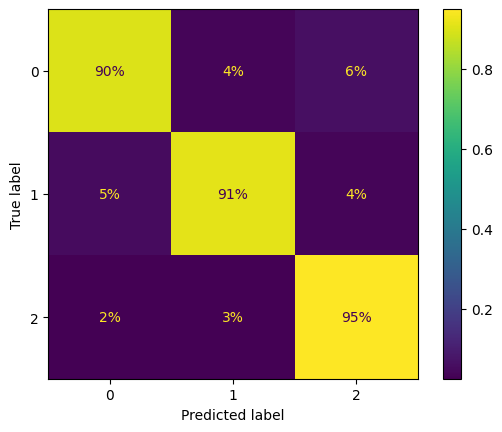

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

predictions = np.argmax(model.predict(val_images_np),axis=1)
#sample_weight = (predictions != val_labels_np)
ConfusionMatrixDisplay.from_predictions(val_labels_np, predictions, normalize="true", values_format=".0%")
plt.show()

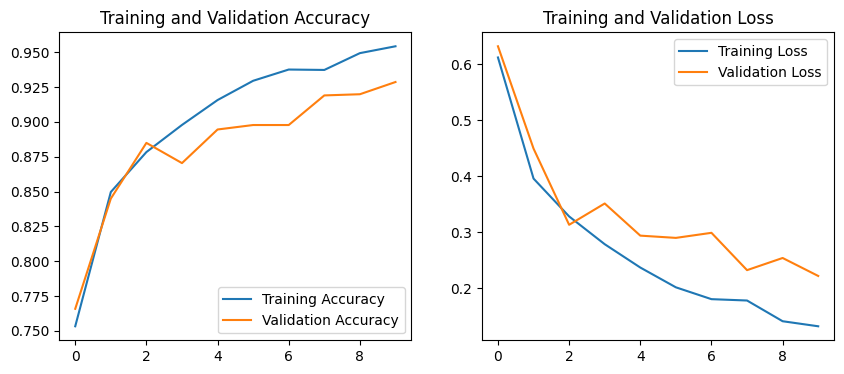

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

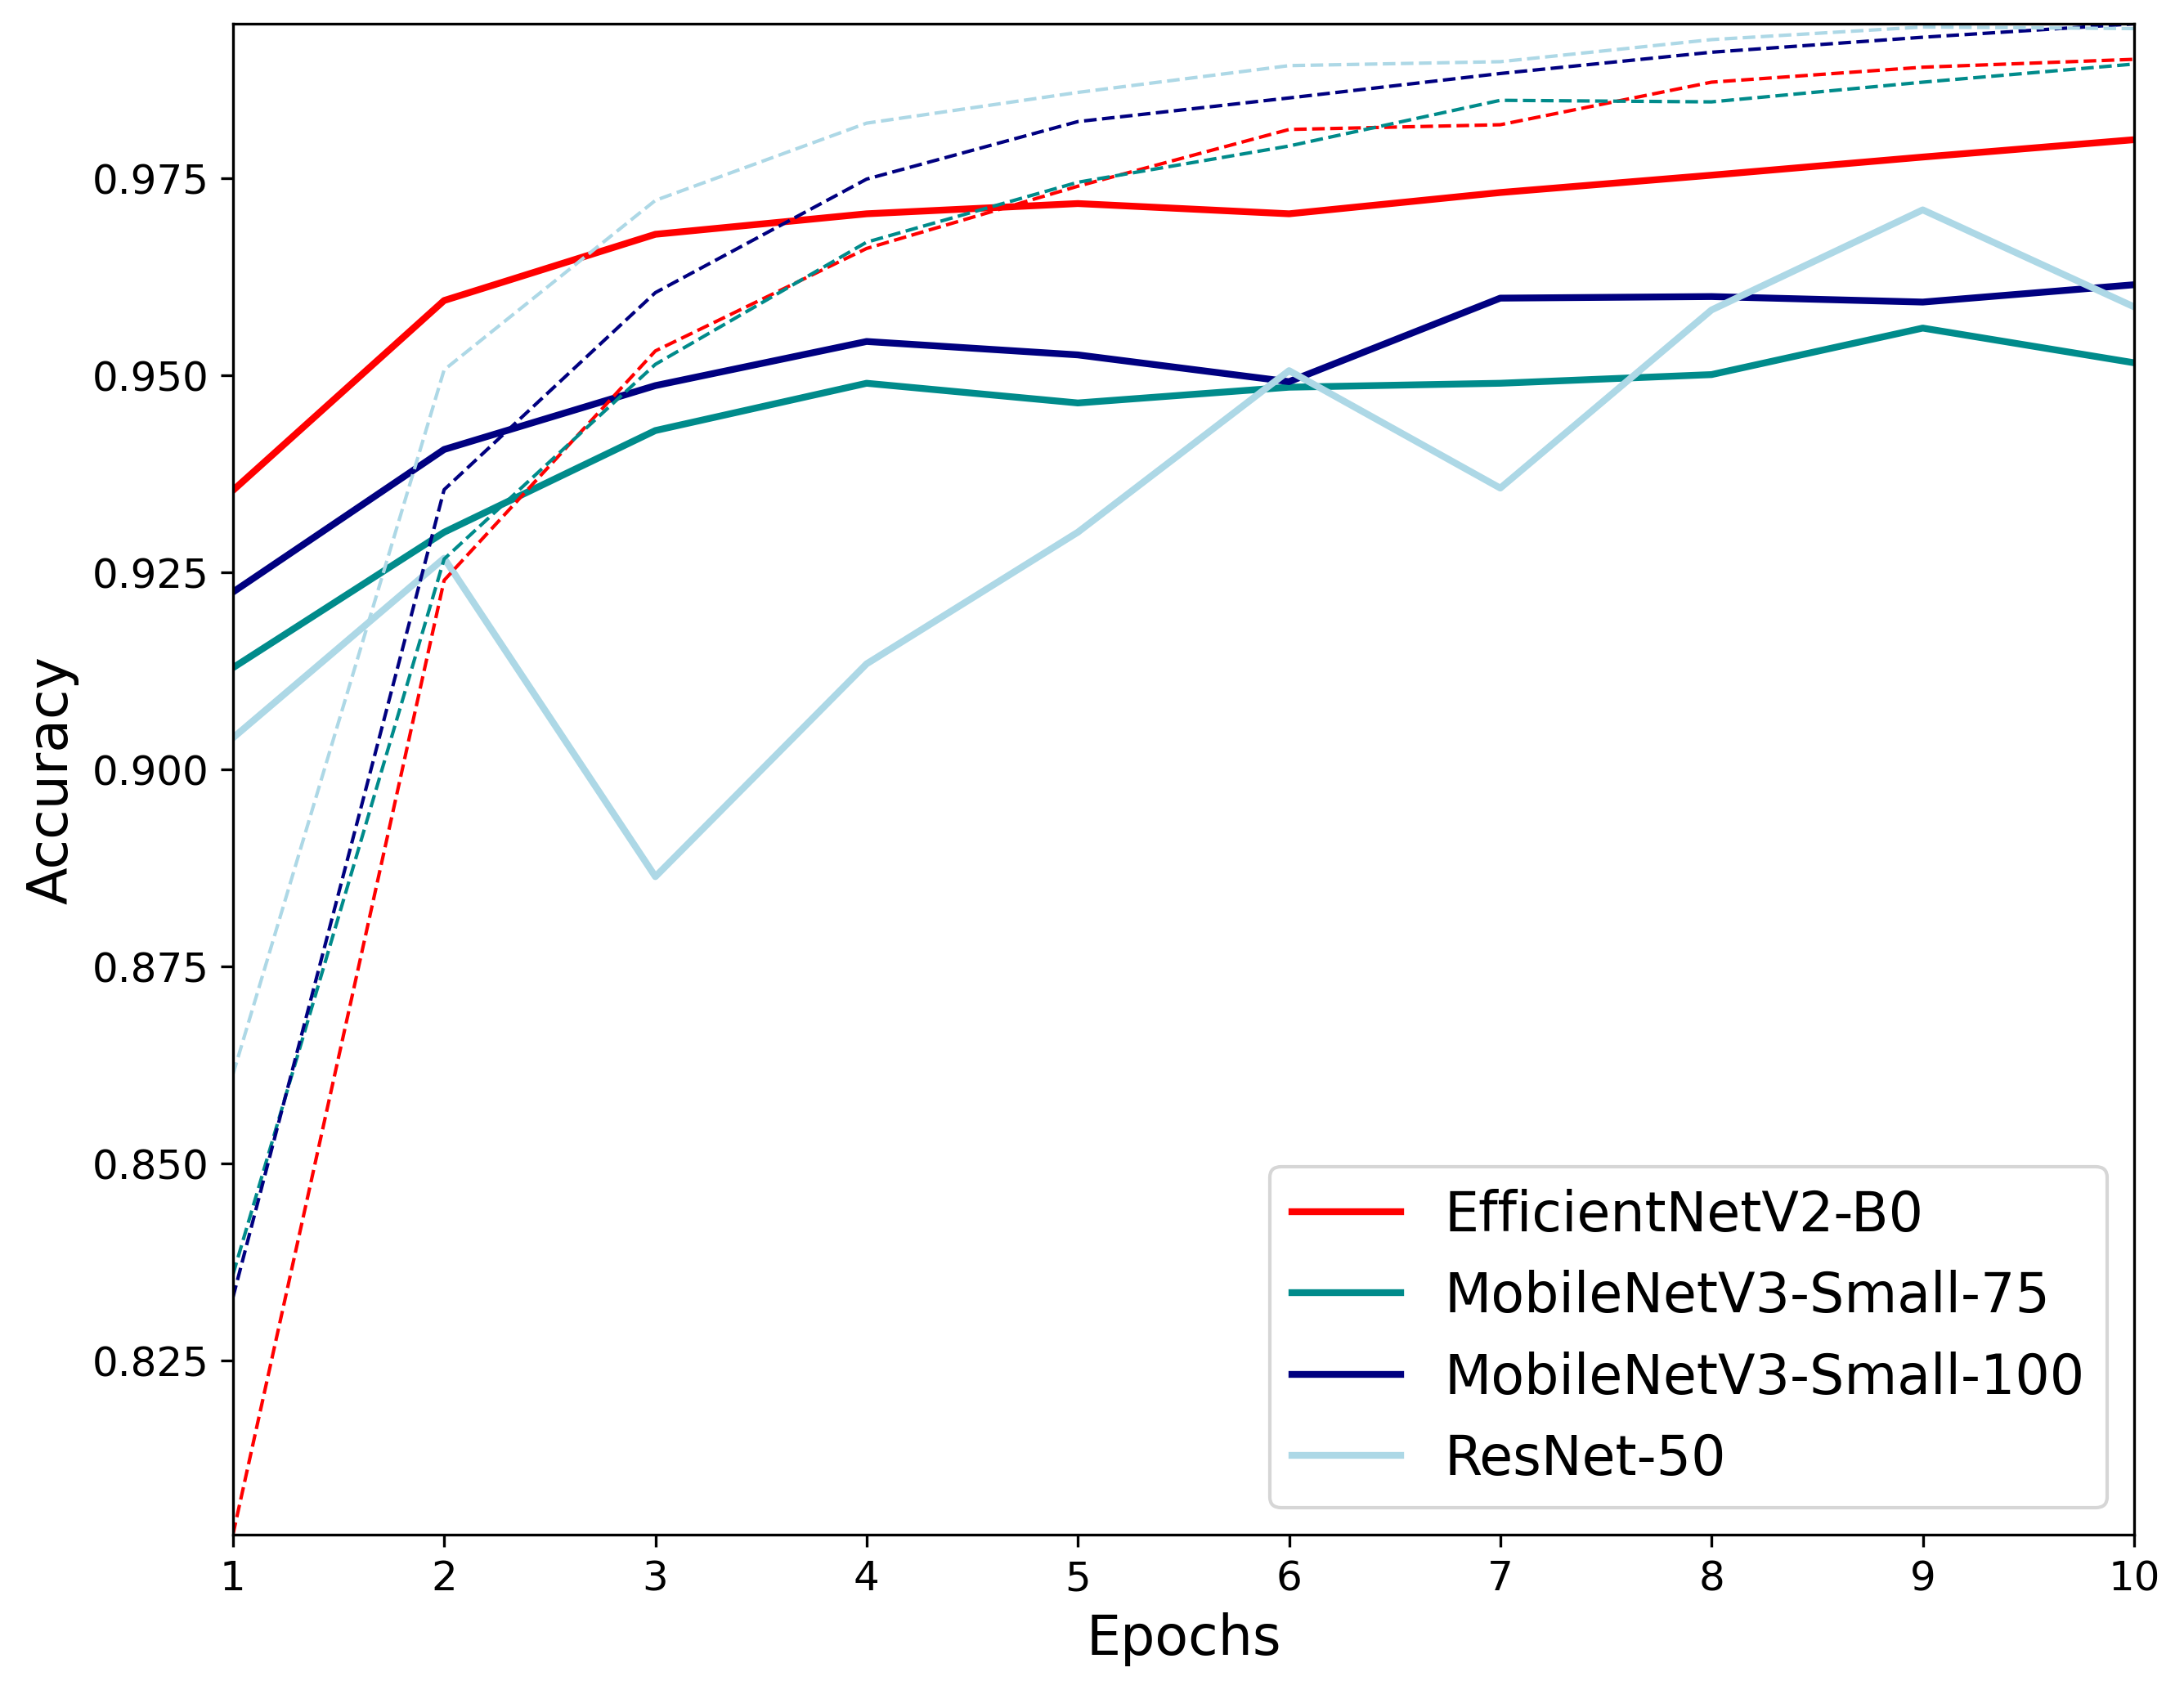

In [14]:
from matplotlib import pyplot as plt

epochs = [1,2,3,4,5,6,7,8,9,10]
labels = ['EfficientNetV2-B0', 'MobileNetV3-Small-75', 'MobileNetV3-Small-100', 'ResNet-50']
labels1 = ['Validation', 'Training']
acc_efficientnet = [0.8029, 0.9240, 0.9531, 0.9661, 0.9740, 0.9812, 0.9818, 0.9872, 0.9891, 0.9901]
val_acc_efficientnet = [0.9354, 0.9595, 0.9679, 0.9705, 0.9718, 0.9705, 0.9732, 0.9754, 0.9777, 0.9799]
acc_mobilenet75 = [0.8359, 0.9267, 0.9514, 0.9669, 0.9745, 0.9791, 0.9849, 0.9847, 0.9872, 0.9895]
val_acc_mobilenet75 = [0.9129, 0.9301, 0.9430, 0.9490, 0.9465, 0.9485, 0.9490, 0.9501, 0.9560, 0.9516]
acc_mobilenet100 = [0.8330, 0.9355, 0.9605, 0.9749, 0.9822, 0.9852, 0.9883, 0.9910, 0.9929, 0.9946]
val_acc_mobilenet100 = [0.9225, 0.9406, 0.9487, 0.9543, 0.9526, 0.9492, 0.9598, 0.9600, 0.9593, 0.9615]
acc_resnet50 = [0.8613, 0.9507, 0.9722, 0.9820, 0.9859, 0.9893, 0.9898, 0.9926, 0.9942, 0.9940]
val_acc_resnet50 = [0.9040, 0.9268, 0.8864, 0.9134, 0.9301, 0.9506, 0.9357, 0.9583, 0.9710, 0.9587]
acc_resnet101 = [0.4112, 0.4270, 0.4372, 0.4370, 0.4379, 0.4389, 0.4440, 0.4448, 0.4477, 0.4494]
val_acc_resnet101 = [0.5427, 0.4819, 0.3559, 0.4885, 0.5118, 0.4038, 0.5172, 0.5381, 0.3765, 0.4902]

fig = plt.figure(figsize= (10,8), dpi=300)
plt.axes(xlabel='Epochs', ylabel='Accuracy', xmargin=0, ymargin=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.plot(epochs, val_acc_efficientnet, color='red', linewidth=2, label = labels[0])
plt.plot(epochs, val_acc_mobilenet75, color='darkcyan', linewidth=2, label = labels[1])
plt.plot(epochs, val_acc_mobilenet100, color='navy', linewidth=2, label = labels[2])
plt.plot(epochs, val_acc_resnet50, color='lightblue', linewidth=2, label = labels[3])
plt.plot(epochs, acc_efficientnet, color='red', linestyle='--', linewidth=1)
plt.plot(epochs, acc_mobilenet75, color='darkcyan',linestyle='--', linewidth=1)
plt.plot(epochs, acc_mobilenet100, color='navy',linestyle='--', linewidth=1)
plt.plot(epochs, acc_resnet50, color='lightblue',linestyle='--', linewidth=1)
#plt.grid()
plt.legend(labels=labels, loc='lower right', fontsize=16)



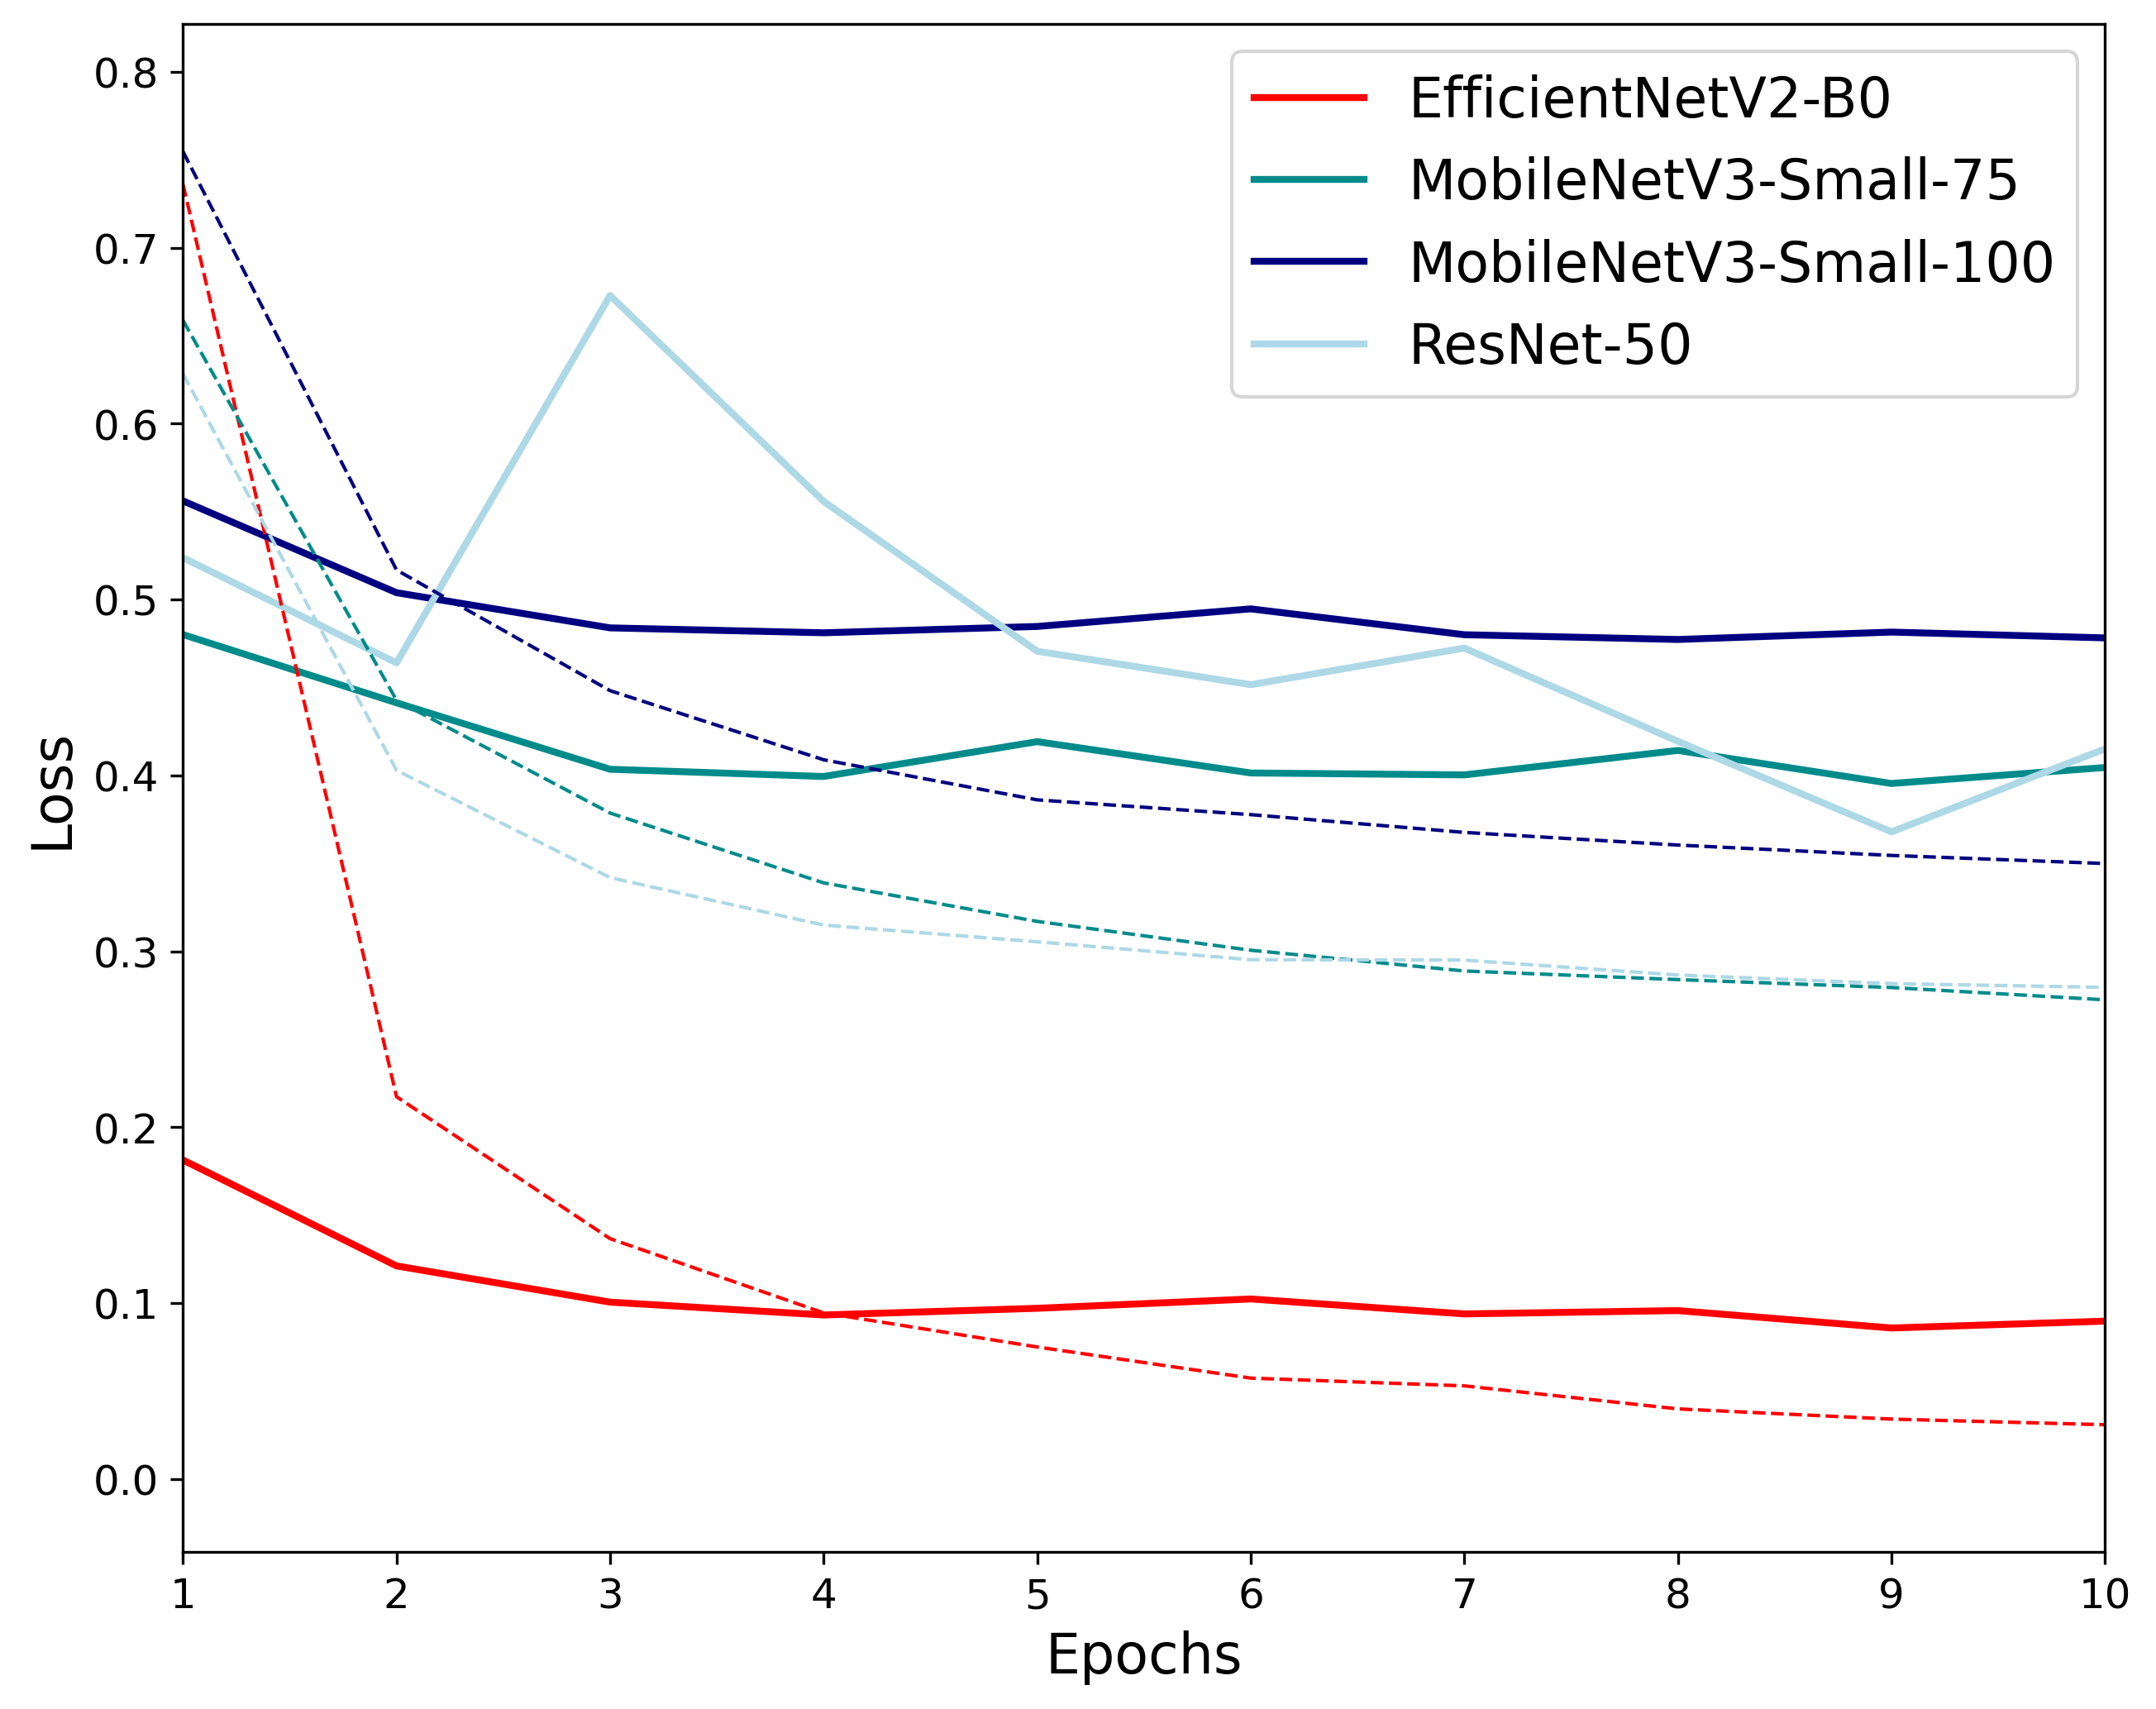

In [15]:
from matplotlib import pyplot as plt

epochs = [1,2,3,4,5,6,7,8,9,10]
labels = ['EfficientNetV2-B0', 'MobileNetV3-Small-75', 'MobileNetV3-Small-100', 'ResNet-50']
labels1 = ['Validation', 'Training']
loss_efficientnet = [0.7362, 0.2173, 0.1366, 0.0944, 0.0750, 0.0573, 0.0529, 0.0398, 0.0340, 0.0308]
val_loss_efficientnet = [0.1813, 0.1211, 0.1005, 0.0932, 0.0970, 0.1023, 0.0938, 0.0957, 0.0858, 0.0897]
loss_mobilenet75 = [0.6588, 0.4427, 0.3786, 0.3389, 0.3170, 0.3006, 0.2888, 0.2839, 0.2794, 0.2724]
val_loss_mobilenet75 = [0.4801, 0.4413, 0.4035, 0.3994, 0.4192, 0.4014, 0.4003, 0.4142, 0.3954, 0.4045]
loss_mobilenet100 = [0.7548, 0.5168, 0.4482, 0.4089, 0.3861, 0.3777, 0.3676, 0.3604, 0.3545, 0.3499]
val_loss_mobilenet100 = [0.5561, 0.5039, 0.4839, 0.4811, 0.4847, 0.4947, 0.4800, 0.4773, 0.4815, 0.4782]
loss_resnet50 = [0.6284, 0.4029, 0.3419, 0.3149, 0.3054, 0.2952, 0.2950, 0.2865, 0.2816, 0.2795]
val_loss_resnet50 = [0.5238, 0.4640, 0.6729, 0.5558, 0.4706, 0.4516, 0.4724, 0.4194, 0.3679, 0.4151]


plt.figure(figsize= (10,8), dpi=300)
plt.axes(xlabel='Epochs', ylabel='Loss', xmargin=0, ymargin=0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.plot(epochs, val_loss_efficientnet, color='red', linewidth=2, label = labels[0])
plt.plot(epochs, val_loss_mobilenet75, color='darkcyan', linewidth=2, label = labels[1])
plt.plot(epochs, val_loss_mobilenet100, color='navy', linewidth=2, label = labels[2])
plt.plot(epochs, val_loss_resnet50, color='lightblue', linewidth=2, label = labels[3])
plt.plot(epochs, loss_efficientnet, color='red', linestyle='--', linewidth=1)
plt.plot(epochs, loss_mobilenet75, color='darkcyan',linestyle='--', linewidth=1)
plt.plot(epochs, loss_mobilenet100, color='navy',linestyle='--', linewidth=1)
plt.plot(epochs, loss_resnet50, color='lightblue',linestyle='--', linewidth=1)
#plt.grid()
plt.legend(labels=labels, loc='upper right', fontsize=16)


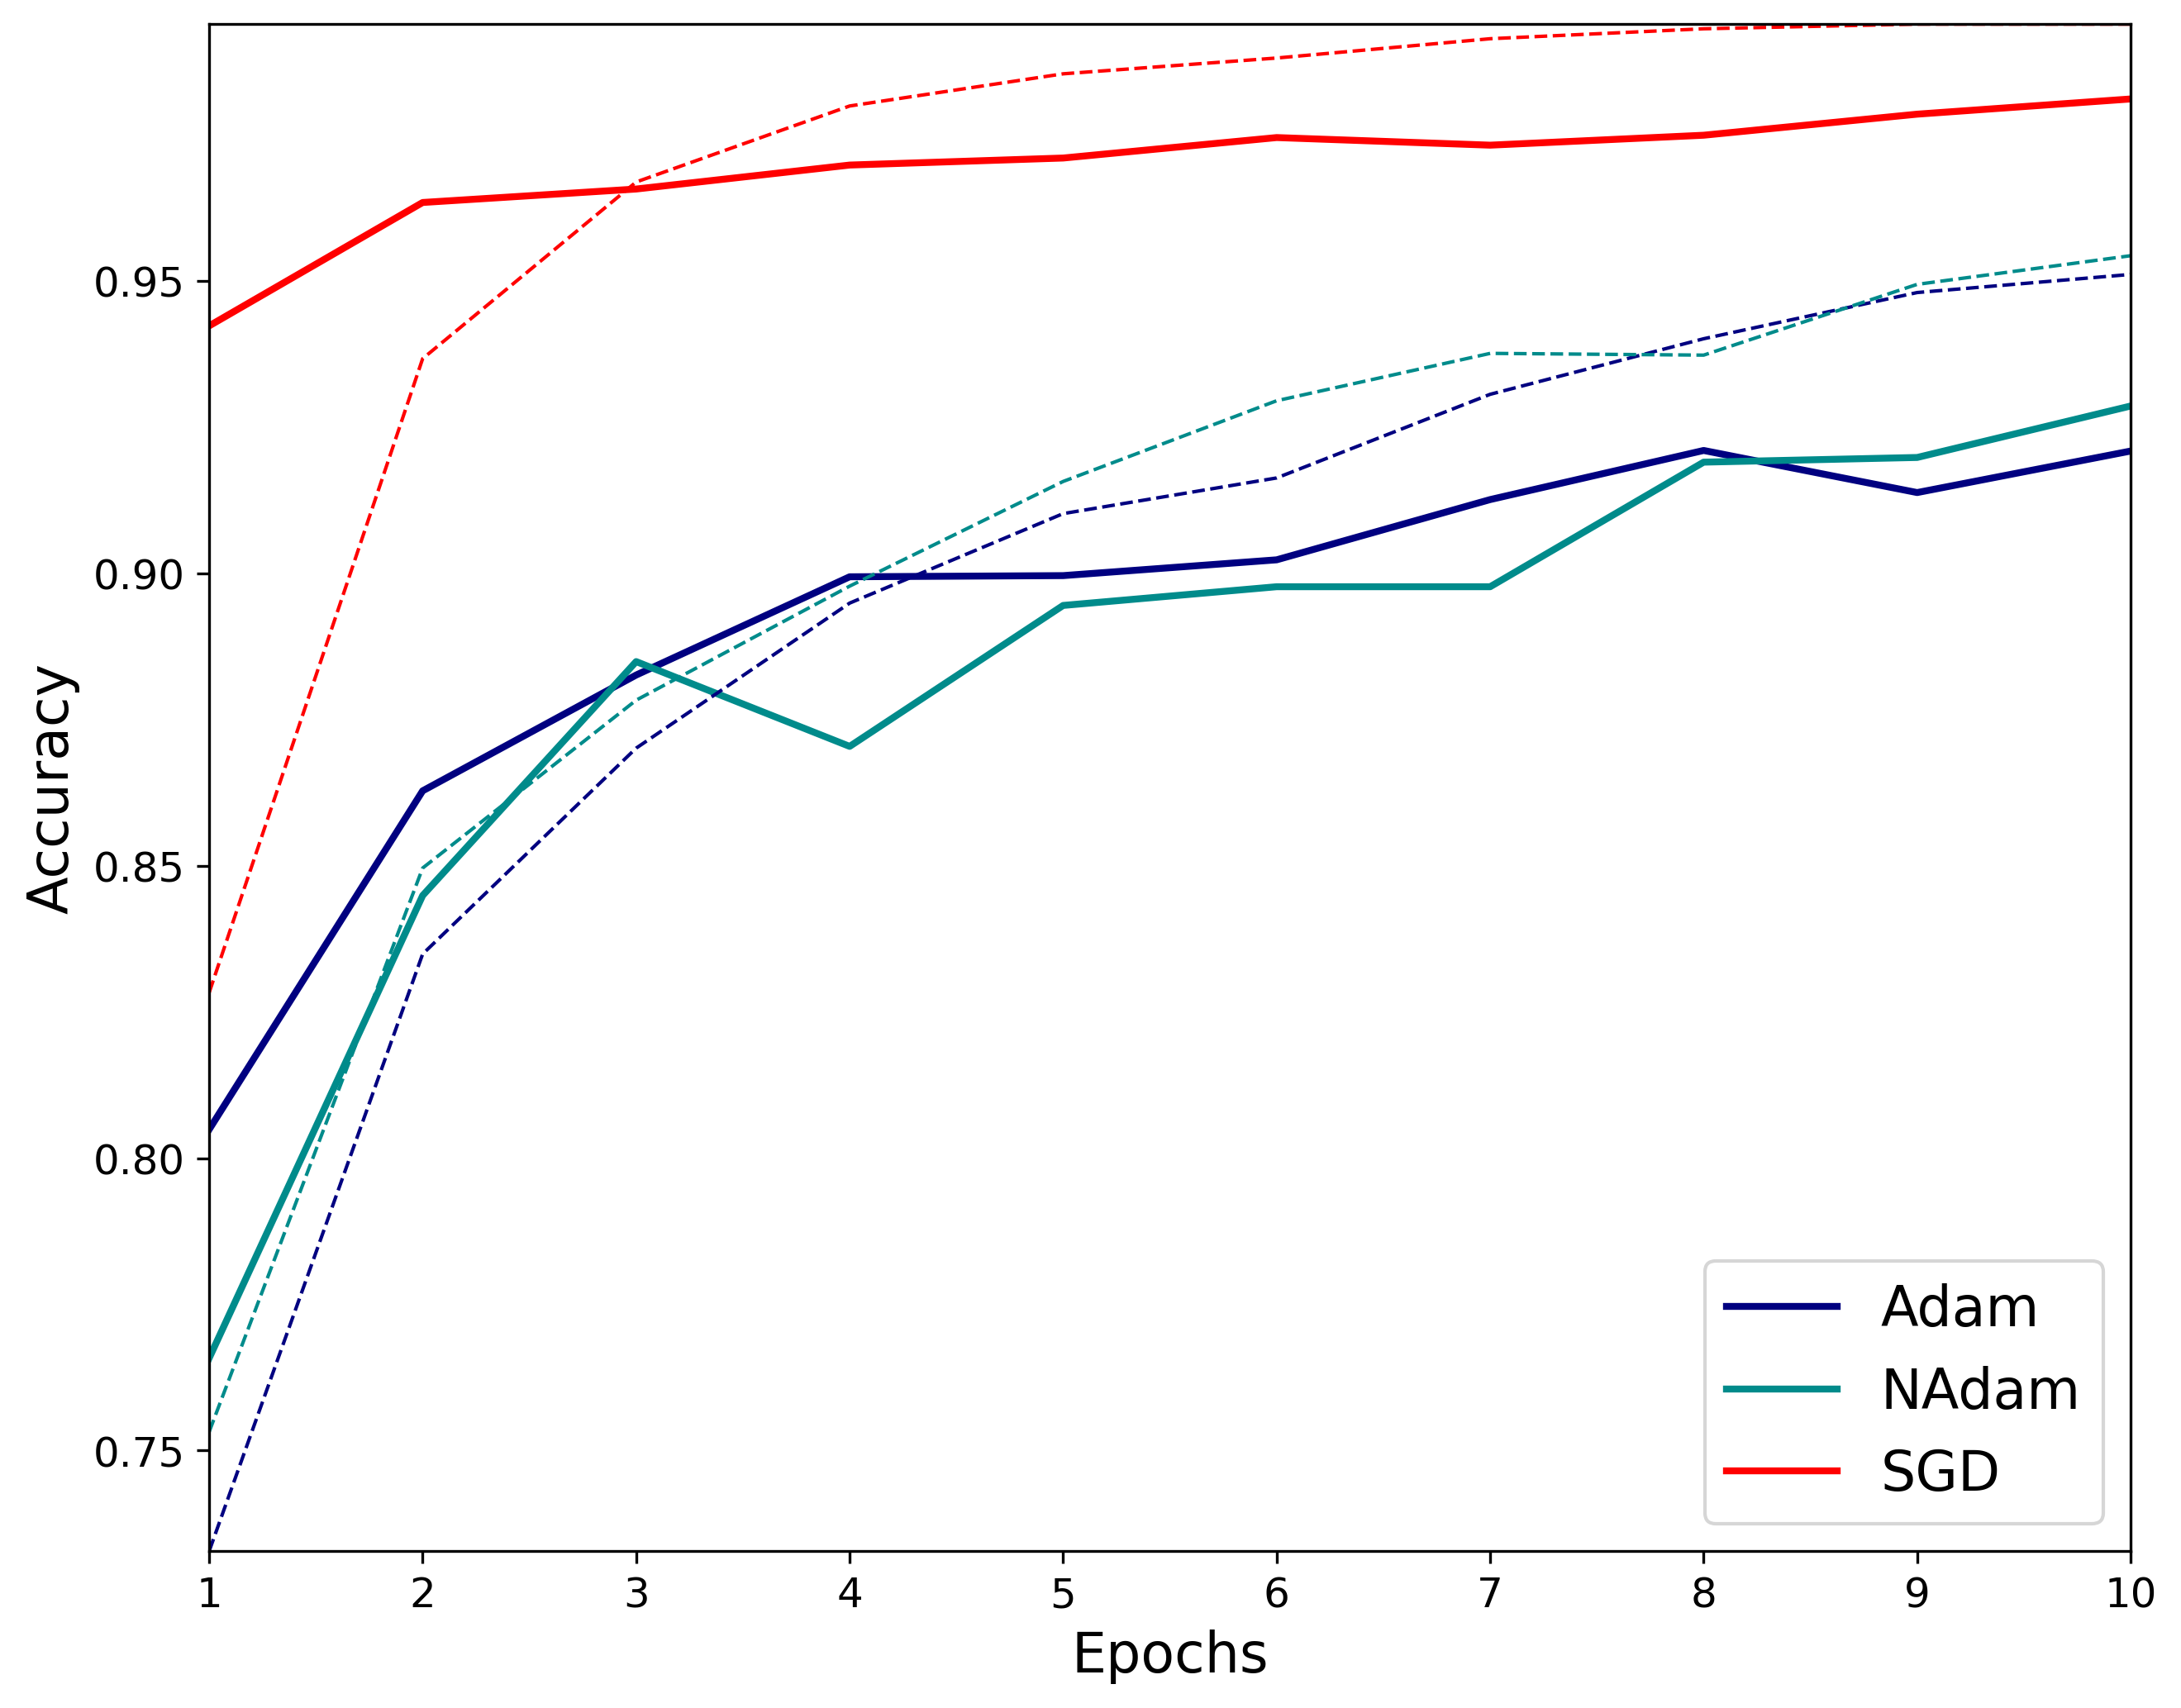

In [11]:
from matplotlib import pyplot as plt

epochs = [1,2,3,4,5,6,7,8,9,10]
labels = ['Adam', 'NAdam', 'SGD']
labels1 = ['Validation', 'Training']
acc_adam = [0.7328, 0.8349, 0.8701, 0.8949, 0.9102, 0.9163, 0.9306, 0.9401, 0.9480, 0.9511]
val_acc_adam = [0.8049, 0.8628, 0.8826, 0.8994, 0.8996, 0.9023, 0.9126, 0.9210, 0.9138, 0.9209]
acc_nadam = [0.7532, 0.8496, 0.8783, 0.8978, 0.9157, 0.9295, 0.9376, 0.9373, 0.9494, 0.9543]
val_acc_nadam = [0.7658, 0.8449, 0.8849, 0.8704, 0.8945, 0.8977, 0.8977, 0.9190, 0.9198, 0.9286]
acc_sgd = [0.8283, 0.9367, 0.9669, 0.9799, 0.9854, 0.9881, 0.9914, 0.9931, 0.9939, 0.9939]
val_acc_sgd = [0.9423, 0.9634, 0.9657, 0.9698, 0.9710, 0.9745, 0.9732, 0.9749, 0.9785, 0.9811]



fig = plt.figure(figsize= (10,8), dpi=300)
plt.axes(xlabel='Epochs', ylabel='Accuracy', xmargin=0, ymargin=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.plot(epochs, val_acc_adam, color='navy', linewidth=2, label = labels[0])
plt.plot(epochs, val_acc_nadam, color='darkcyan', linewidth=2, label = labels[1])
plt.plot(epochs, val_acc_sgd, color='red', linewidth=2, label = labels[2])
plt.plot(epochs, acc_adam, color='navy', linestyle='--', linewidth=1)
plt.plot(epochs, acc_nadam, color='darkcyan',linestyle='--', linewidth=1)
plt.plot(epochs, acc_sgd, color='red',linestyle='--', linewidth=1)
#plt.grid()
plt.legend(labels=labels, loc='lower right', fontsize=16)

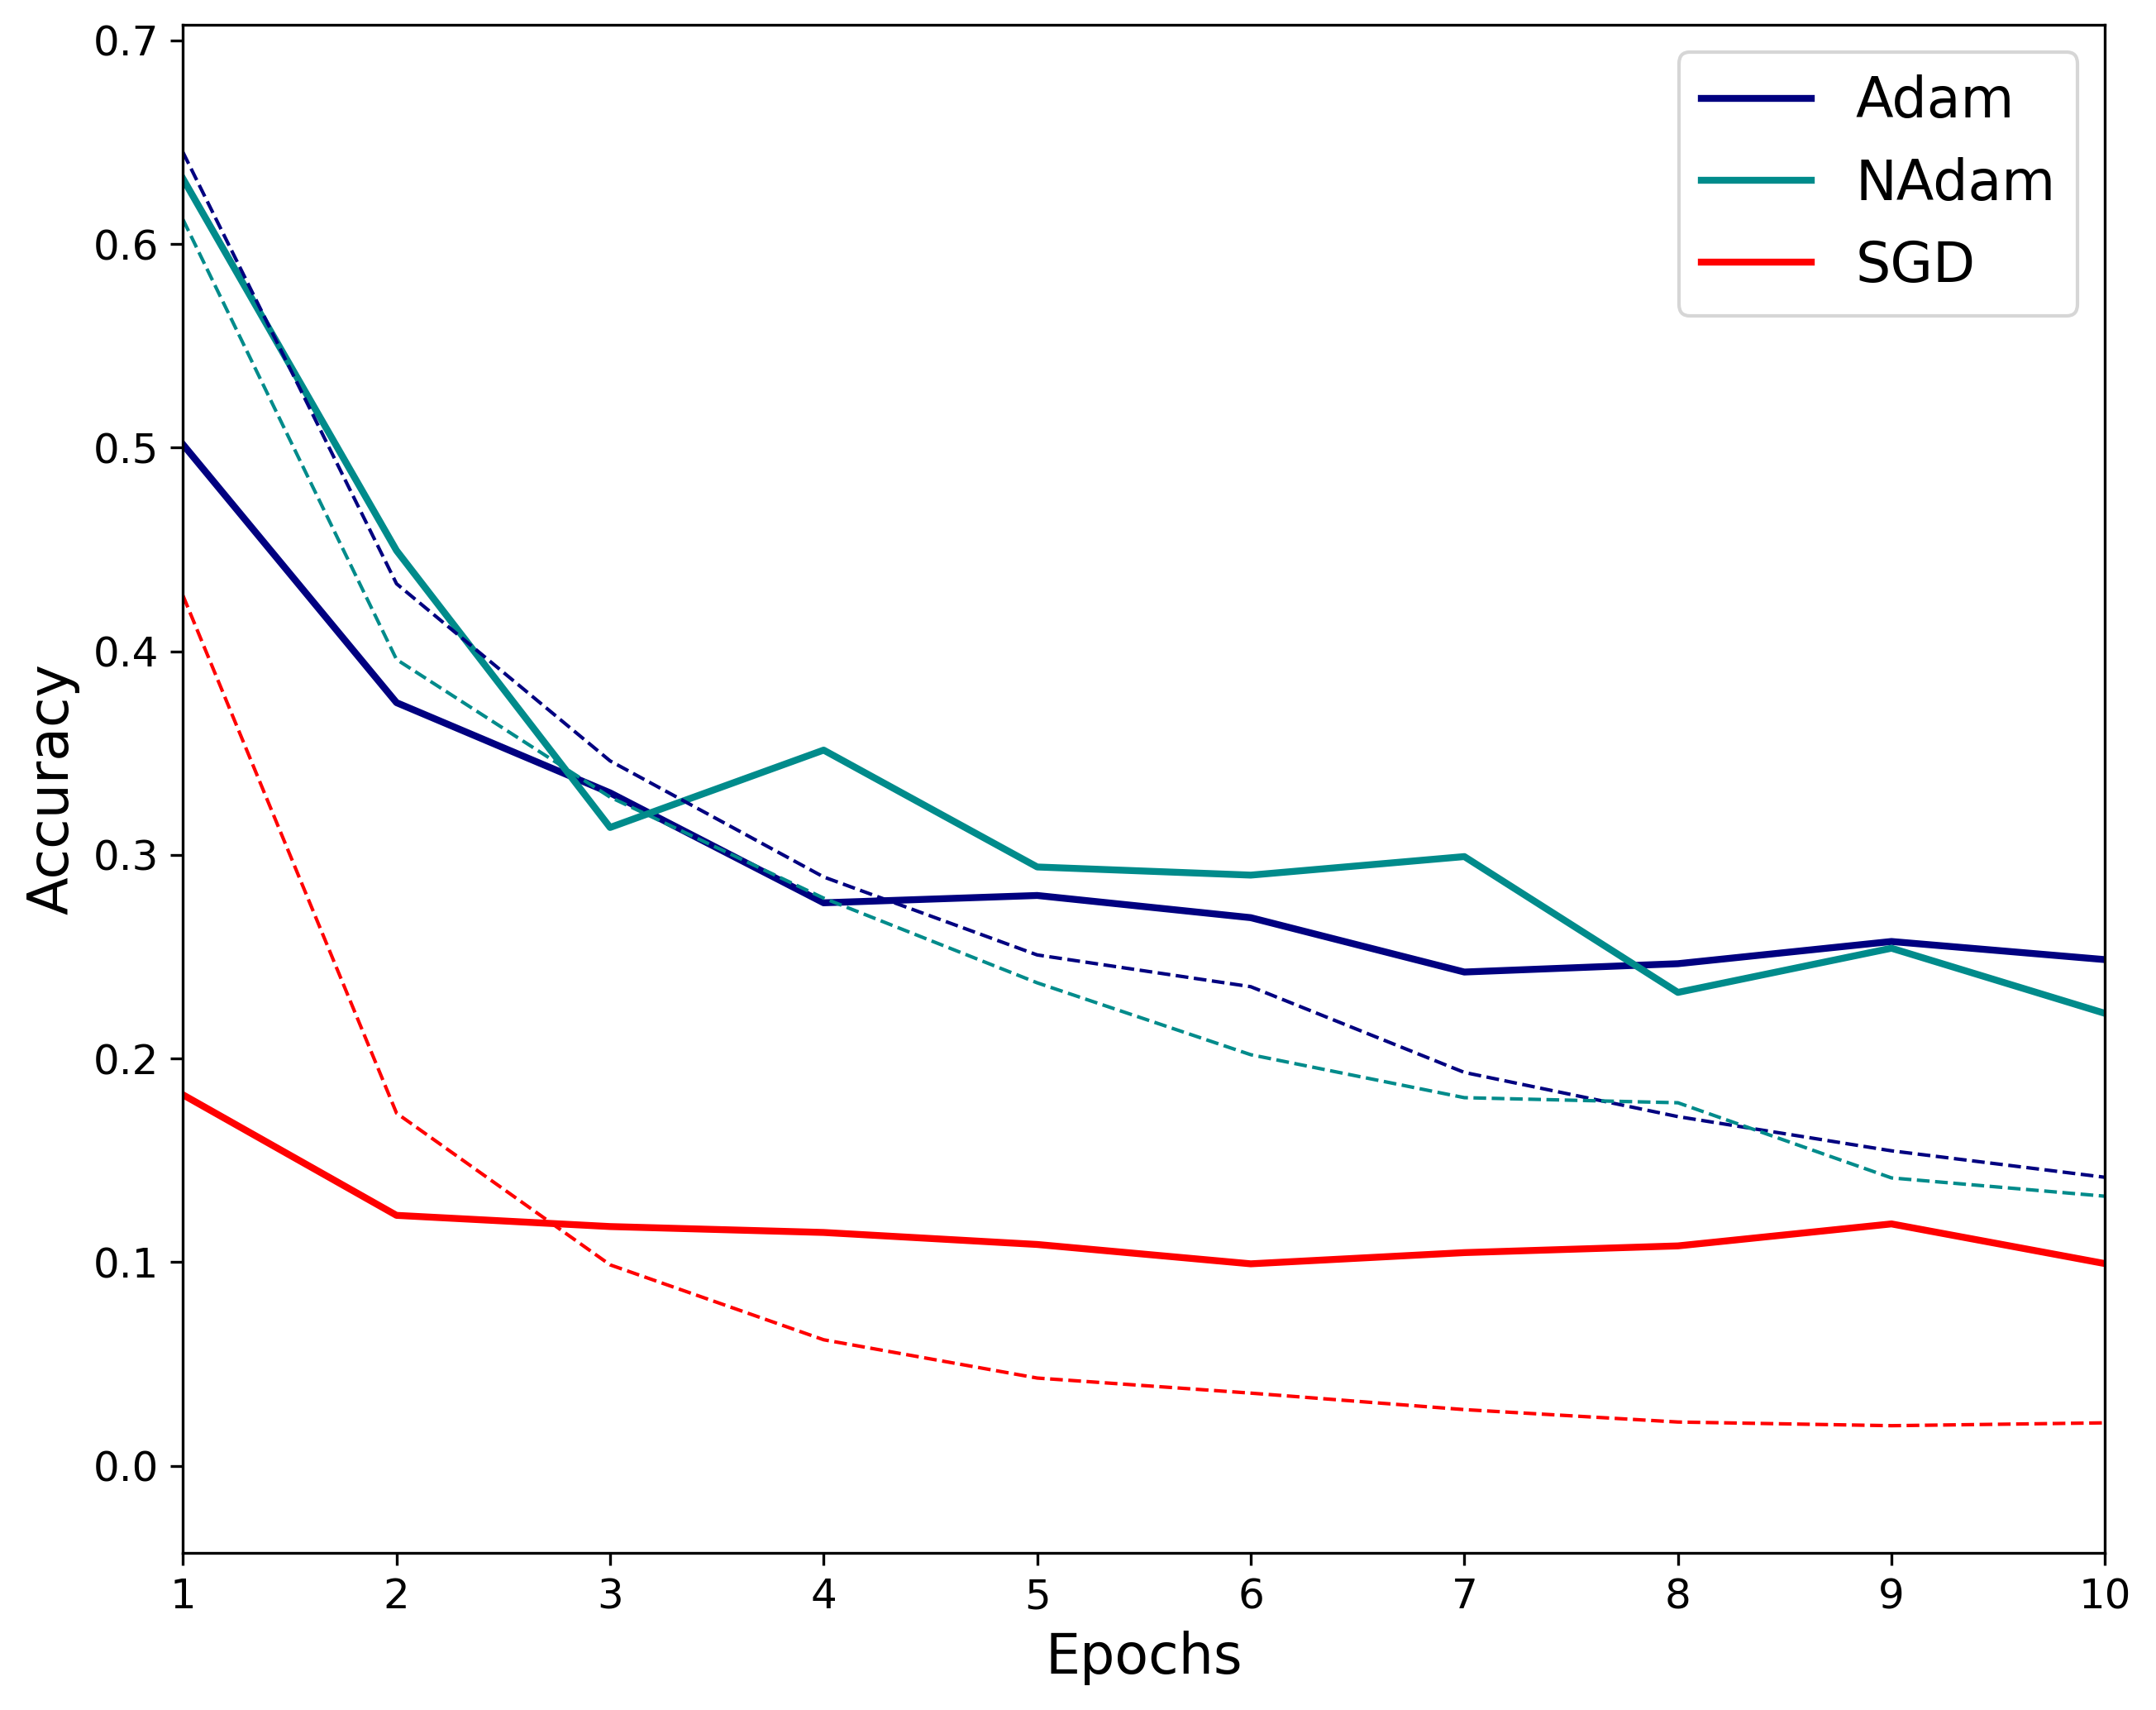

In [12]:
from matplotlib import pyplot as plt

epochs = [1,2,3,4,5,6,7,8,9,10]
labels = ['Adam', 'NAdam', 'SGD']
labels1 = ['Validation', 'Training']
loss_adam = [0.6451, 0.4332, 0.3462, 0.2892, 0.2509, 0.2353, 0.1932, 0.1715, 0.1547, 0.1417]
val_loss_adam = [0.5016, 0.3748, 0.3305, 0.2765, 0.2801, 0.2692, 0.2425, 0.2466, 0.2575, 0.2486]
loss_nadam = [0.6121, 0.3960, 0.3284, 0.2788, 0.2372, 0.2019, 0.1808, 0.1783, 0.1414, 0.1324]
val_loss_nadam = [0.6321, 0.4495, 0.3135, 0.3515, 0.2941, 0.2901, 0.2992, 0.2325, 0.2542, 0.2222]
loss_sgd = [0.4274, 0.1732, 0.0987, 0.0619, 0.0431, 0.0357, 0.0276, 0.0215, 0.0197, 0.0211]
val_loss_sgd = [0.1822, 0.1230, 0.1175, 0.1146, 0.1087, 0.0992, 0.1047, 0.1080, 0.1188, 0.0993]



fig = plt.figure(figsize= (10,8), dpi=300)
plt.axes(xlabel='Epochs', ylabel='Accuracy', xmargin=0, ymargin=0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.plot(epochs, val_loss_adam, color='navy', linewidth=2, label = labels[0])
plt.plot(epochs, val_loss_nadam, color='darkcyan', linewidth=2, label = labels[1])
plt.plot(epochs, val_loss_sgd, color='red', linewidth=2, label = labels[2])
plt.plot(epochs, loss_adam, color='navy', linestyle='--', linewidth=1)
plt.plot(epochs, loss_nadam, color='darkcyan',linestyle='--', linewidth=1)
plt.plot(epochs, loss_sgd, color='red',linestyle='--', linewidth=1)
#plt.grid()
plt.legend(labels=labels, loc='upper right', fontsize=16)

In [ ]:
var1 = [1, 2, 3, 4, 5]
var2 = [1, 4, 3, 2, 1]

plt.figure(figsize=(10,8), dpi=300)

plt.plot(var1, var2, color="black", label='Validation')
plt.plot(var2, var1, color="black", linestyle="--", label='Training')
plt.legend()

In [12]:
model.save('/Users/alexwilson/Documents/University/ThirdYear/IndividualProject/coding/models/efficientnetAdam.keras')

In [15]:
weights = model.get_weights()
print(weights)
model.save_weights("/Users/alexwilson/Documents/University/ThirdYear/IndividualProject/coding/models/efficientNetNadam.weights.h5")

[array([[[[-5.48980981e-02, -3.82597178e-01, -1.87941343e-01, ...,
           1.08604521e-01, -1.49747387e-01, -1.92697346e-01],
         [ 3.47884335e-02,  2.84441471e-01, -4.32565093e-01, ...,
           3.74951422e-01, -7.79273331e-01, -6.30159557e-01],
         [-2.10092619e-01,  6.34520471e-01,  2.36902833e-01, ...,
          -2.25424692e-01,  6.22481644e-01,  1.62900463e-01],
         ...,
         [ 1.18499768e+00, -1.32143223e+00, -2.04447657e-01, ...,
          -3.41126561e-01,  3.13902795e-01, -5.01805067e-01],
         [ 2.70297527e-01, -4.35752124e-01, -3.23814303e-01, ...,
          -2.40368322e-01, -2.71048188e-01, -6.50104061e-02],
         [ 3.89618665e-01,  1.10380776e-01, -6.27181605e-02, ...,
          -6.63204119e-02,  4.30633277e-01,  3.62422178e-03]],

        [[-6.79822713e-02,  1.90392941e-01, -2.29610816e-01, ...,
           1.17064767e-01, -2.48173162e-01, -3.50228637e-01],
         [ 3.80743474e-01, -1.87562734e-01,  5.26556194e-01, ...,
          -1.30154312